In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt

from io import BytesIO

Federal Reserve Yield Curve Data 

US yield curve data is available from the Federal Researve as detailed at the following url: 
https://www.federalreserve.gov/data/nominal-yield-curve.htm
The data is available in csv and xml format

In [43]:
# Download ECB yield curve data
yield_curve_url = 'https://www.federalreserve.gov/data/yield-curve-tables/feds200628.csv'
response = requests.get(yield_curve_url)

# Open response content in pandas dataframe
curve_raw_data = pd.read_csv(BytesIO(response.content), skiprows=9, parse_dates=['Date'], index_col='Date')

curve_raw_data.rename({x:x.replace('SVENY','SR_').replace('SVENF','IF_').replace('SVENPY','PY_').replace('_0','_') for x in curve_raw_data.columns}, axis=1, inplace=True)
curve_raw_data.rename({x:f'{x}Y' for x in curve_raw_data.columns if x[:3] in ['SR_','IF_','PY_']}, axis=1, inplace=True)

curve_raw_data.tail().transpose()

Date,2024-07-08,2024-07-09,2024-07-10,2024-07-11,2024-07-12
BETA0,1.995113,2.122222,2.206908,2.373877,2.598370
BETA1,3.554267,3.459830,3.381048,3.188193,3.020048
BETA2,0.000074,0.000099,-0.000061,0.000072,0.000055
BETA3,7.803915,7.547860,7.235311,6.629250,5.961610
SVEN1F01,4.244100,4.241700,4.235700,4.091200,4.018300
...,...,...,...,...,...
SR_28Y,4.545600,4.578200,4.561100,4.510800,4.504300
SR_29Y,4.537000,4.569600,4.553700,4.506300,4.501200
SR_30Y,4.526700,4.559400,4.544700,4.500300,4.496800
TAU1,1.745866,1.647127,1.615365,1.401564,1.189196


In [44]:
# Generate a dictionary of tenor lengths
tenor_dict = {f'{x:}Y': x for x in range(1, 31)}

# Tenor dict subset
tenor_dict_subset = {f'{x:}Y': x for x in range(1, 31)}

In [52]:
# Calculate unique values in the dataset
par_rate = curve_raw_data[[x for x in curve_raw_data.columns if x[:2]=='PY']].copy()
par_rate.rename({f'PY_{x}Y':f'{x}Y' for x in range(1, 31)}, axis=1, inplace=True)
fwd_rate = curve_raw_data[[x for x in curve_raw_data.columns if x[:2]=='IF']].copy()
fwd_rate.rename({f'IF_{x}Y':f'{x}Y' for x in range(1, 31)}, axis=1, inplace=True)
spot_rate = curve_raw_data[[x for x in curve_raw_data.columns if x[:2]=='SR']].copy()
spot_rate.rename({f'SR_{x}Y':f'{x}Y' for x in range(1, 31)}, axis=1, inplace=True)

# Get maximum date
curve_date = np.max(curve_raw_data.index)

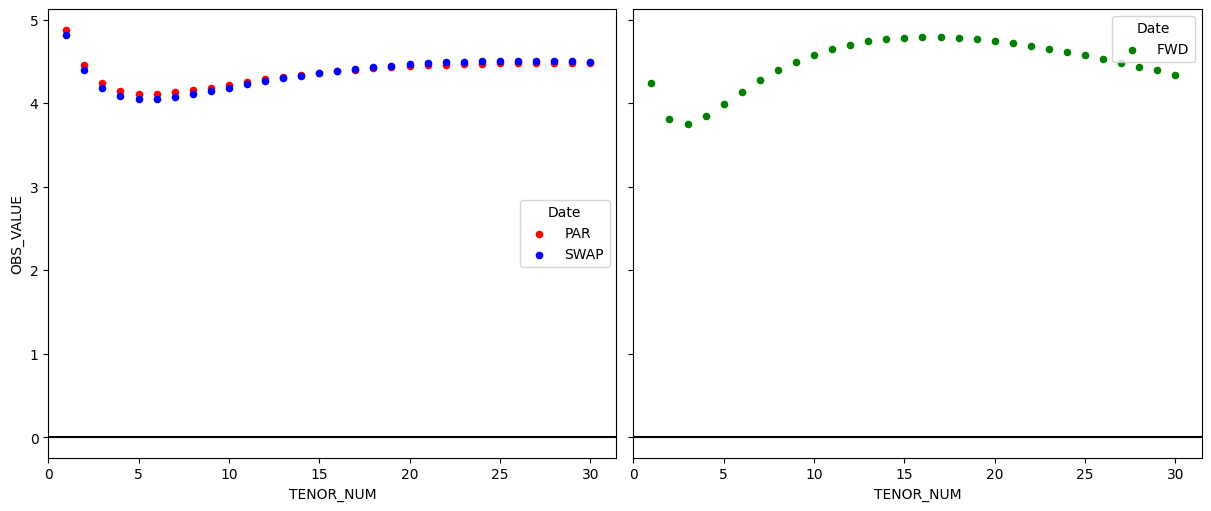

In [48]:
curve_single_day = curve_raw_data.loc[[curve_date]].dropna(axis=1).transpose().rename({curve_date:'OBS_VALUE'}, axis=1)
curve_single_day['DATA_TYPE_FM'] = curve_single_day.index
curve_single_day['CURVE_TYPE'] = curve_single_day.DATA_TYPE_FM.str.split('_').str[0]
curve_single_day['TENOR'] =curve_single_day.DATA_TYPE_FM.str.split('_').str[-1]
curve_single_day['TENOR_NUM'] = curve_single_day['TENOR'].replace(tenor_dict)

fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True, sharey=True, sharex=True, figsize=(12,5))

# Plot par yields with swap rates
curve_single_day[(curve_single_day.CURVE_TYPE == 'PY')].sort_values('TENOR_NUM').plot.scatter('TENOR_NUM', 'OBS_VALUE', ax=ax1, label='PAR', color='r')
curve_single_day[(curve_single_day.CURVE_TYPE == 'SR')].sort_values('TENOR_NUM').plot.scatter('TENOR_NUM', 'OBS_VALUE', ax=ax1, label='SWAP', color='b')

# Plot forward rates
curve_single_day[(curve_single_day.CURVE_TYPE == 'IF')].sort_values('TENOR_NUM').plot.scatter('TENOR_NUM', 'OBS_VALUE', ax=ax2, label='FWD', color='g')

# Set ax1 range
ax1.set_xlim(0)
ax1.axhline(0, color='black')
ax2.axhline(0, color='black')

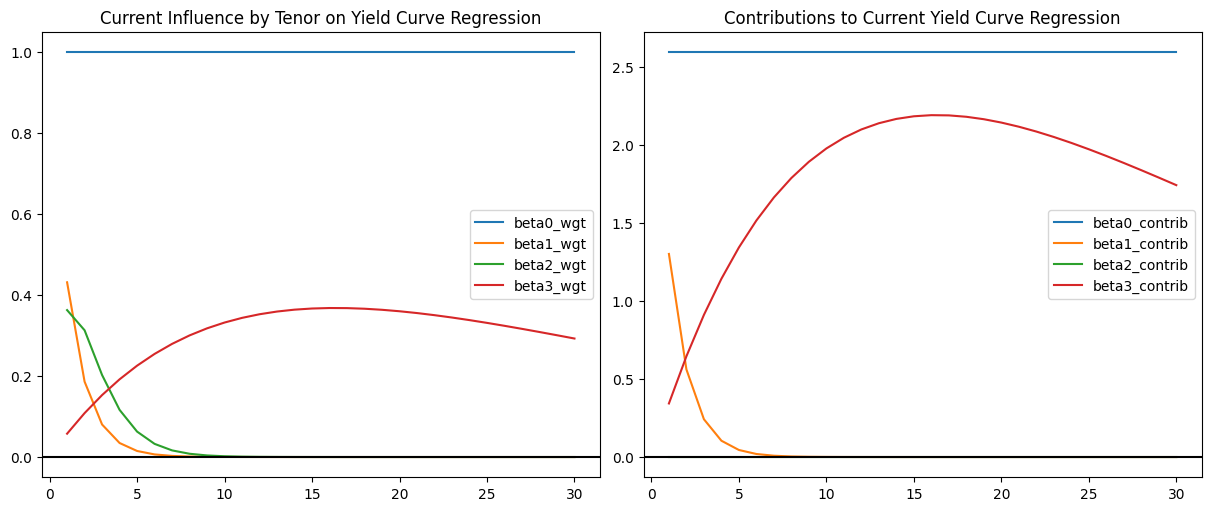

In [49]:
### Visualising the ECB regression parameters for the yield curve
beta0 = curve_single_day.set_index('CURVE_TYPE').loc['BETA0', 'OBS_VALUE']
beta1 = curve_single_day.set_index('CURVE_TYPE').loc['BETA1', 'OBS_VALUE']
beta2 = curve_single_day.set_index('CURVE_TYPE').loc['BETA2', 'OBS_VALUE']
beta3 = curve_single_day.set_index('CURVE_TYPE').loc['BETA3', 'OBS_VALUE']

tau1 = curve_single_day.set_index('CURVE_TYPE').loc['TAU1', 'OBS_VALUE']
tau2 = curve_single_day.set_index('CURVE_TYPE').loc['TAU2', 'OBS_VALUE']

fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True, sharex=True, figsize=(12,5))

# Get ECB curve model regression exhibits
curve_model = pd.DataFrame(index=tenor_dict.values()).sort_index().copy()
curve_model['tenor'] = curve_model.index
curve_model['beta0_wgt'] = 1
curve_model['beta1_wgt'] = curve_model.tenor.apply(lambda x: np.exp(-x / tau1))
curve_model['beta2_wgt'] = curve_model.tenor.apply(lambda x: np.exp(-x / tau1)) * curve_model.tenor / tau1
curve_model['beta3_wgt'] = curve_model.tenor.apply(lambda x: np.exp(-x / tau2)) * curve_model.tenor / tau2
curve_model[[x for x in curve_model.columns if '_wgt' in x]].plot(ax=ax1, title='Current Influence by Tenor on Yield Curve Regression')
ax1.axhline(0, color='black')

# Visualising the contributions of each parameter to the yield curve
curve_model['beta0_contrib'] = curve_model.beta0_wgt * beta0
curve_model['beta1_contrib'] = curve_model.beta1_wgt * beta1
curve_model['beta2_contrib'] = curve_model.beta2_wgt * beta2
curve_model['beta3_contrib'] = curve_model.beta3_wgt * beta3
curve_model[[x for x in curve_model.columns if '_contrib' in x]].plot(ax=ax2, title='Contributions to Current Yield Curve Regression')
ax2.axhline(0, color='black')

In [59]:
rate_vol_regression

,tenor,corr: spot rate vol to level,corr: fwd rate vol to level
1Y,1,None,None
2Y,2,None,None
3Y,3,None,None
4Y,4,None,None
5Y,5,None,None
6Y,6,None,None
7Y,7,None,None
8Y,8,None,None
9Y,9,None,None
10Y,10,None,None


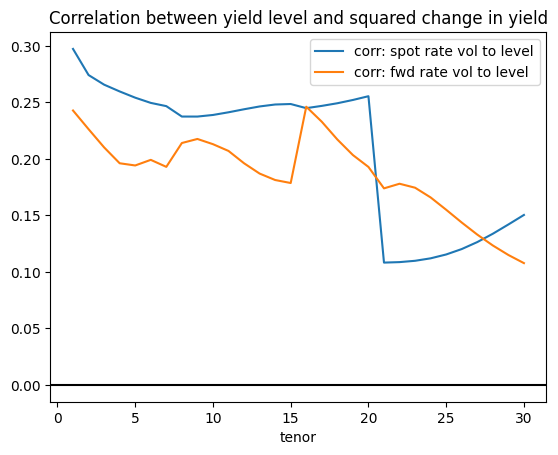

In [60]:
period_length = 5

# Calculate curve changes
par_rate_change = - par_rate.diff(periods=-period_length)
fwd_rate_change = - fwd_rate.diff(periods=-period_length)
spot_rate_change = - spot_rate.diff(periods=-period_length)

# Regress squared level changes against level
rate_vol_regression = pd.DataFrame({'tenor':tenor_dict})
rate_vol_regression['corr: spot rate vol to level'] = None
rate_vol_regression['corr: fwd rate vol to level'] = None

for tenor in rate_vol_regression.index:
    try:
        rate_vol_regression.loc[tenor, 'corr: spot rate vol to level'] = (spot_rate_change[tenor] ** 2).corr(spot_rate[tenor])
    except:
        pass
    try:
        rate_vol_regression.loc[tenor, 'corr: fwd rate vol to level'] = (fwd_rate_change[tenor] ** 2).corr(fwd_rate[tenor])
    except:
        pass
    
fig, ax = plt.subplots()
rate_vol_regression.sort_values('tenor').plot(x='tenor', y=[x for x in rate_vol_regression.columns if 'corr' in x], title='Correlation between yield level and squared change in yield', ax=ax)
ax.axhline(0, color='black')

[]

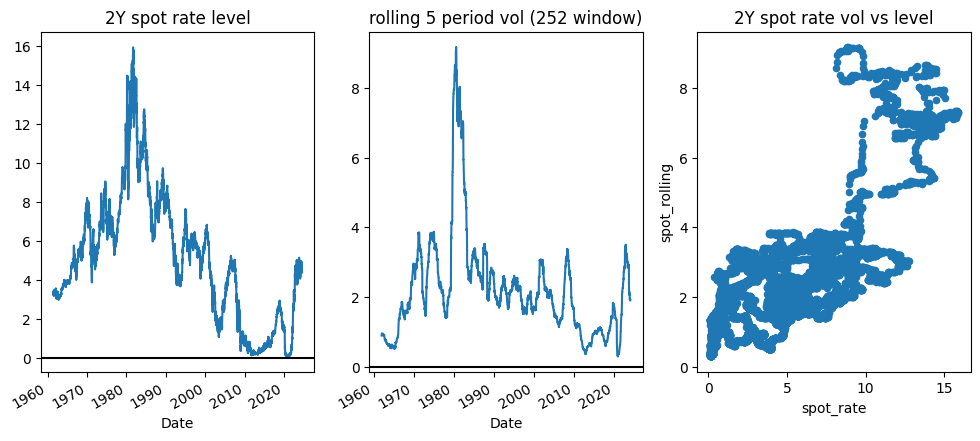

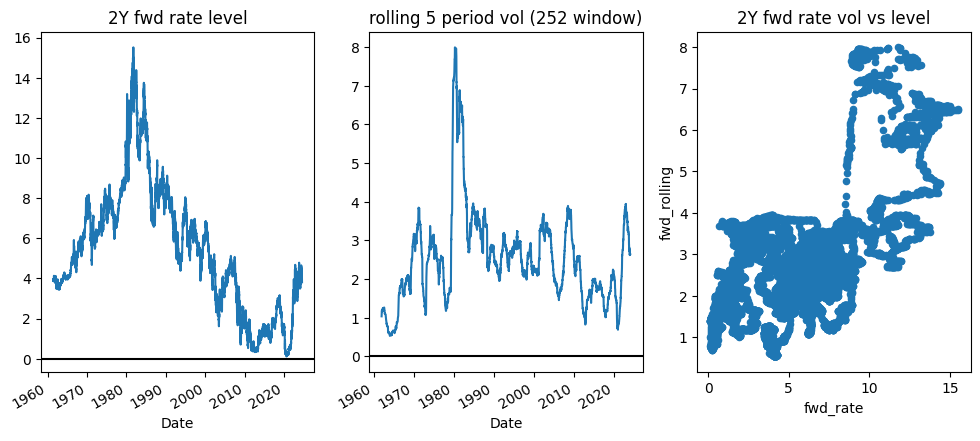

In [55]:
tenor = '2Y'
period_length = 5
rolling_length = 252

single_tenor_ts = pd.DataFrame({'spot_rate': spot_rate[tenor], 'fwd_rate': fwd_rate[tenor]}).dropna()
single_tenor_ts.rename({f'IF_{tenor}': 'fwd_rate', f'SR_{tenor}':'spot_rate'}, axis=1, inplace=True)
single_tenor_ts['fwd_change'] = - single_tenor_ts.fwd_rate.diff(periods=-period_length)
single_tenor_ts['fwd_vol'] = single_tenor_ts.fwd_change**2
single_tenor_ts['fwd_rolling'] = single_tenor_ts.fwd_change.rolling(rolling_length).std().shift(int(-rolling_length/2)) * 252 ** 0.5

single_tenor_ts['spot_change'] = - single_tenor_ts.spot_rate.diff(periods=-period_length)
single_tenor_ts['spot_vol'] = single_tenor_ts.spot_change**2
single_tenor_ts['spot_rolling'] = single_tenor_ts.spot_change.rolling(rolling_length).std().shift(int(-rolling_length/2)) * 252 ** 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
single_tenor_ts.spot_rate.plot(ax=ax1, title=f'{tenor} spot rate level')
ax1.axhline(0, color='black')
single_tenor_ts.spot_rolling.plot(ax=ax2, title=f'rolling {period_length} period vol ({rolling_length} window)')
ax2.axhline(0, color='black')
single_tenor_ts.plot.scatter('spot_rate', 'spot_rolling', ax=ax3, title=f'{tenor} spot rate vol vs level')
plt.plot()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
single_tenor_ts.fwd_rate.plot(ax=ax1, title=f'{tenor} fwd rate level')
ax1.axhline(0, color='black')
single_tenor_ts.fwd_rolling.plot(ax=ax2, title=f'rolling {period_length} period vol ({rolling_length} window)')
ax2.axhline(0, color='black')
single_tenor_ts.plot.scatter('fwd_rate', 'fwd_rolling', ax=ax3, title=f'{tenor} fwd rate vol vs level')
plt.plot()

In [ ]:
regression_parameters = curve_raw_data[curve_raw_data.DATA_TYPE_FM.str[:3].isin(['BET', 'TAU'])].pivot(index='TIME_PERIOD', columns='DATA_TYPE_FM', values='OBS_VALUE').copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
regression_parameters[[x for x in regression_parameters if 'BETA' in x]].plot(ax=ax1, title=f'Yield Curve Betas')
ax1.axhline(0, color='black')
regression_parameters[[x for x in regression_parameters if 'TAU' in x]].plot(ax=ax2, title=f'Yield Curve Locations (tau values)')
ax2.axhline(0, color='black')
plt.plot()